In [1]:
import sys
sys.path.append('../code')
from synthetic_funcs import *
import torch as t 
import torch.nn.functional as F
import numpy as np
import tqdm
import matplotlib.pylab as plt
import matplotlib.cm as cm
import json
import hyperparams
from importlib import reload
from sklearn.decomposition import PCA

%matplotlib inline
plt.rcParams['figure.figsize']=(12,9)


In [2]:
run_num = 10 
epoch_num = 2000
exp_ver = '8'

start_lambda1 = 0.5
start_temp  = 1.0

# Data preparation

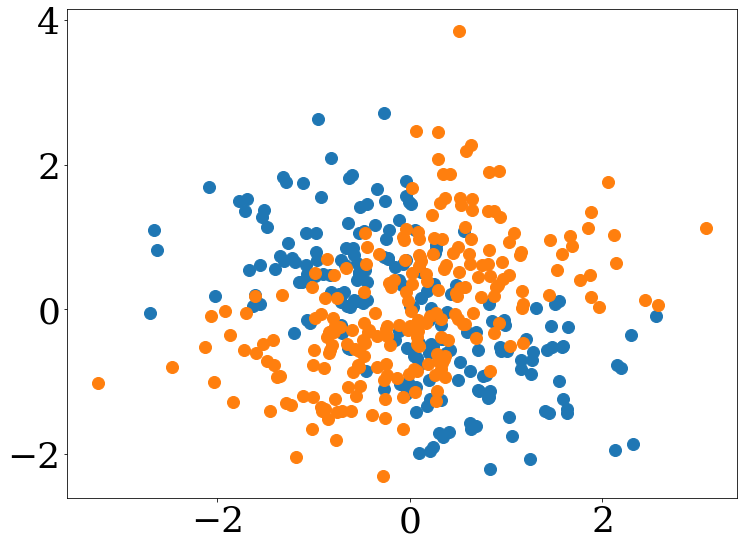

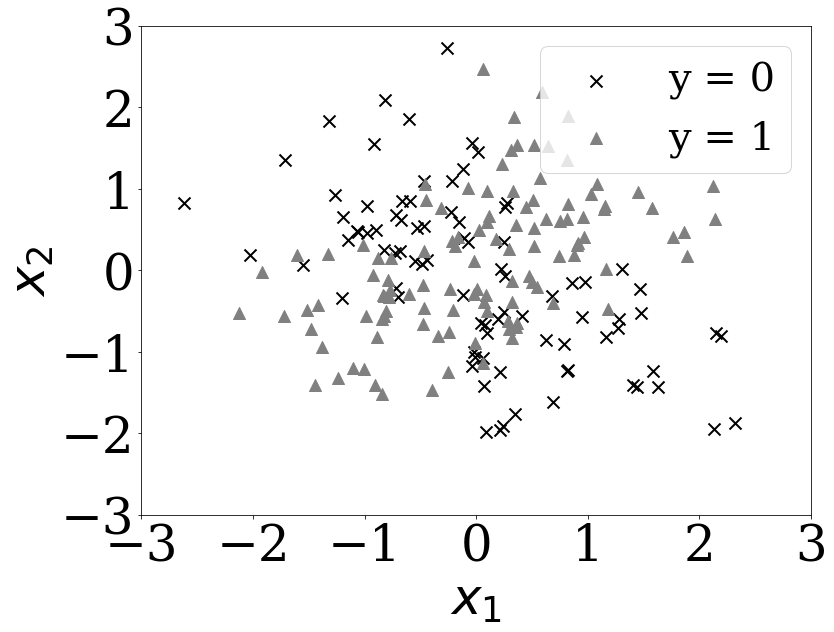

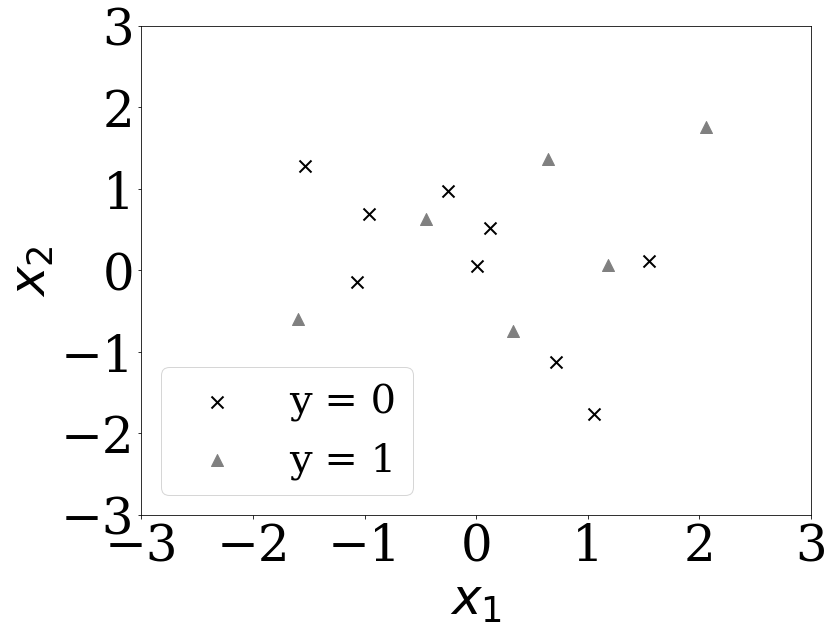

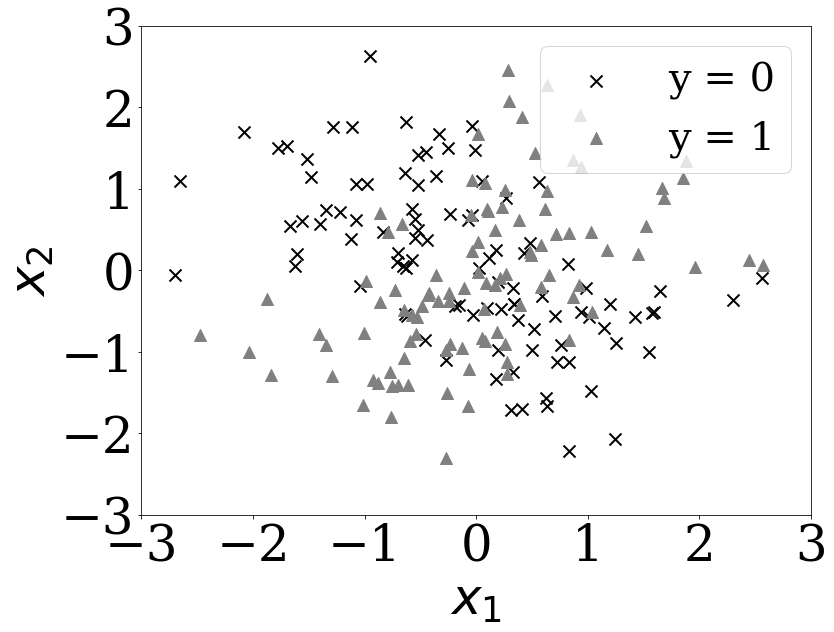

In [6]:
np.random.seed(42)
teacher_train_size, student_train_size, student_validation_size, test_size = 200, 15, 15, 200
total_size =  sum([teacher_train_size, student_train_size, student_validation_size, test_size])
eps = .5
plt.rcParams['font.size']= 10
plt.rcParams['font.family']= 'serif'
"""
Y генерируется как:
    sign (x1 * x2) + шум
    
Признаки для учителя:
    x1; x2; индикатор, что x1 >0 и x2>0 
    Последний признак коррелирует с Y, но не покрывает его
    
Признаки для ученика:
    x1; x2; индикатор, что x1 >0 и x2>0 
    Последний признак отличается от Y из-за шума
        
    
"""
# полные данные
x_big = np.random.randn(total_size, 2)
y_big = (np.sign(x_big[:,0]*x_big[:,1]+np.random.randn(total_size)*eps)+1)//2
x_big = np.vstack([x_big[:,0], x_big[:,1],  (np.sign(x_big[:,0])+np.sign(x_big[:,1]) >0.1)*1.0, 
                   np.sign(x_big[:,0]*x_big[:,1])]).T

# обучение учителя. NB: не пересекается с выборкой для обучения ученика, так проще подобрать параметры
x_ttrain = t.tensor(x_big[:teacher_train_size], dtype=t.float32)
y_ttrain = t.tensor(y_big[:teacher_train_size], dtype=t.long)


# обучение ученика
x_train = t.tensor(x_big[teacher_train_size:teacher_train_size+student_train_size], dtype=t.float32)
y_train = t.tensor(y_big[teacher_train_size:teacher_train_size+student_train_size], dtype=t.long)

# валидация, в этом ноутбуке не используется
x_val = t.tensor(x_big[teacher_train_size+student_train_size:teacher_train_size+student_train_size+student_validation_size], 
                 dtype=t.float32)
y_val = t.tensor(y_big[teacher_train_size+student_train_size:teacher_train_size+student_train_size+student_validation_size], dtype=t.long)


x_test = t.tensor(x_big[-test_size:], dtype=t.float32)
y_test = t.tensor(y_big[-test_size:], dtype=t.long)

plt.scatter(x_big[y_big==0,0], x_big[y_big==0,1])
plt.scatter(x_big[y_big==1,0], x_big[y_big==1,1])

plt.show()

plt.scatter(x_ttrain[y_ttrain==0,0], x_ttrain[y_ttrain==0,1], label='y = 0', marker='x', color='black')
plt.scatter(x_ttrain[y_ttrain==1,0], x_ttrain[y_ttrain==1,1], label='y = 1', marker='^', color='grey')
plt.xlabel(r'$x_1$', fontsize=50)
plt.ylabel(r'$x_2$', fontsize=50)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.legend(fontsize=40)
plt.savefig('../figs/ttrain_greyscale.png', bbox_inches='tight')
#plt.legend()
plt.show()

plt.scatter(x_train[y_train==0,0], x_train[y_train==0,1], label='y = 0', marker='x', color='black')
plt.scatter(x_train[y_train==1,0], x_train[y_train==1,1], label='y = 1', marker='^', color='grey')
plt.xlabel(r'$x_1$', fontsize=50)
plt.ylabel(r'$x_2$', fontsize=50)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.legend(fontsize=40)
plt.savefig('../figs/train_greyscale.png', bbox_inches='tight')
#plt.legend()
plt.show()

plt.scatter(x_test[y_test==0,0], x_test[y_test==0,1], label='y = 0', marker='x', color='black')
plt.scatter(x_test[y_test==1,0], x_test[y_test==1,1], label='y = 1', marker='^', color='grey')
plt.xlabel(r'$x_1$', fontsize=50)
plt.ylabel(r'$x_2$', fontsize=50)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.legend(fontsize=40)
plt.savefig('../figs/test_greyscale.png', bbox_inches='tight')

plt.show()


In [8]:
x_big.shape

(4, 430)

# Experiments

### teacher training

In [6]:
# обучение учителя

teacher=net_training(20000, x_net_train=x_ttrain, y_net_train=y_ttrain, x_net_test=x_test,
             y_net_test=y_test, order=[0,1,2], lr0=1e-2)

0.575
0.615
0.66
0.665
0.665
0.67
0.665
0.675
0.675
0.685
0.685
0.69
0.69
0.69
0.685
0.69
0.69
0.69
0.69
0.69


### without distillation

In [12]:
# обучение студента без дистилляции

start_lambda1=1.0
start_temp=1.0

filename=None
synthetic_base(exp_ver, 1, epoch_num, start_lambda1, start_temp, filename, order=[0,1,3], 
               teacher=teacher, x_train=x_train, y_train=y_train, 
               x_test=x_test, y_test=y_test, lr0=1.0)

../code/synthetic_funcs.py:44: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  g = F.log_softmax(out/temp)


{'epoch': 0, 'accuracy': 0.6549999713897705, 'temp': 1.0, 'lambda1': 1.0}
{'epoch': 200, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 1.0}
{'epoch': 400, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 1.0}
{'epoch': 600, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 1.0}
{'epoch': 800, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 1.0}
{'epoch': 1000, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 1.0}
{'epoch': 1200, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 1.0}
{'epoch': 1400, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 1.0}
{'epoch': 1600, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 1.0}
{'epoch': 1800, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 1.0}


TypeError: can only concatenate str (not "NoneType") to str

### full distillation

In [11]:
# полная дистилляция

start_lambda1 = 0.0
start_temp = 1.0

filename=None
synthetic_base(exp_ver, 1, epoch_num, start_lambda1, start_temp, filename, order=[0,1,3], 
               teacher=teacher, x_train=x_train, y_train=y_train, 
               x_test=x_test, y_test=y_test, lr0=1.0)

0.615
0.56
0.56
0.56
0.56
0.56
0.56
0.56
0.56
0.56


### distillation with different coefficients

In [14]:
# дистилляция с разными коэффициентами

start_lambda1=1.0
start_temp=1.0

filename='nodistil'
synthetic_base(exp_ver, 10, epoch_num, start_lambda1, start_temp, filename, order=[0,1,3], 
               teacher=teacher, x_train=x_train, y_train=y_train, 
               x_test=x_test, y_test=y_test, lr0=1.0)

{'epoch': 0, 'accuracy': 0.6549999713897705, 'temp': 1.0, 'lambda1': 1.0}
{'epoch': 200, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 1.0}
{'epoch': 400, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 1.0}
{'epoch': 600, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 1.0}
{'epoch': 800, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 1.0}
{'epoch': 1000, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 1.0}
{'epoch': 1200, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 1.0}
{'epoch': 1400, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 1.0}
{'epoch': 1600, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 1.0}
{'epoch': 1800, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 1.0}
{'epoch': 0, 'accuracy': 0.45500001311302185, 'temp': 1.0, 'lambda1': 1.0}
{'epoch': 200, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 1.0}
{'epoch': 400, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 1.0}
{'epoch': 

In [15]:
# дистилляция с разными коэффициентами

start_lambda1 = .5
start_temp = 1.0

filename='distil'
synthetic_base(exp_ver, 10, epoch_num, start_lambda1, start_temp, filename, order=[0,1,2], 
               teacher=teacher, x_train=x_train, y_train=y_train, 
               x_test=x_test, y_test=y_test, lr0=1.0)

{'epoch': 0, 'accuracy': 0.625, 'temp': 1.0, 'lambda1': 0.5}
{'epoch': 200, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 0.5}
{'epoch': 400, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 0.5}
{'epoch': 600, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 0.5}
{'epoch': 800, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 0.5}
{'epoch': 1000, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 0.5}
{'epoch': 1200, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 0.5}
{'epoch': 1400, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 0.5}
{'epoch': 1600, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 0.5}
{'epoch': 1800, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 0.5}
{'epoch': 0, 'accuracy': 0.45500001311302185, 'temp': 1.0, 'lambda1': 0.5}
{'epoch': 200, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 0.5}
{'epoch': 400, 'accuracy': 0.6299999952316284, 'temp': 1.0, 'lambda1': 0.5}
{'epoch': 600, 'accurac

### distillation with random meta-parameters

In [16]:
# дистилляция со случайными гиперпараметрами
# NB: здесь оставляем такую же инициализацию параметров, что и раньше! 
# это так задумано

filename='random'
synthetic_base(exp_ver, run_num, epoch_num, start_lambda1, start_temp, filename, order=[0,1,2], teacher=teacher,
               x_train=x_train, y_train=y_train, 
               x_test=x_test, y_test=y_test, mode='random', lr0=1.0)

{'epoch': 0, 'accuracy': 0.5899999737739563, 'temp': 7.969455242156982, 'lambda1': 0.3745401203632355}
{'epoch': 200, 'accuracy': 0.550000011920929, 'temp': 7.969455242156982, 'lambda1': 0.3745401203632355}
{'epoch': 400, 'accuracy': 0.550000011920929, 'temp': 7.969455242156982, 'lambda1': 0.3745401203632355}
{'epoch': 600, 'accuracy': 0.550000011920929, 'temp': 7.969455242156982, 'lambda1': 0.3745401203632355}
{'epoch': 800, 'accuracy': 0.550000011920929, 'temp': 7.969455242156982, 'lambda1': 0.3745401203632355}
{'epoch': 1000, 'accuracy': 0.550000011920929, 'temp': 7.969455242156982, 'lambda1': 0.3745401203632355}
{'epoch': 1200, 'accuracy': 0.550000011920929, 'temp': 7.969455242156982, 'lambda1': 0.3745401203632355}
{'epoch': 1400, 'accuracy': 0.550000011920929, 'temp': 7.969455242156982, 'lambda1': 0.3745401203632355}
{'epoch': 1600, 'accuracy': 0.550000011920929, 'temp': 7.969455242156982, 'lambda1': 0.3745401203632355}
{'epoch': 1800, 'accuracy': 0.550000011920929, 'temp': 7.9694

{'epoch': 1600, 'accuracy': 0.7049999833106995, 'temp': 0.23270677030086517, 'lambda1': 0.1818249672651291}
{'epoch': 1800, 'accuracy': 0.7149999737739563, 'temp': 0.23270677030086517, 'lambda1': 0.1818249672651291}
{'epoch': 0, 'accuracy': 0.44999998807907104, 'temp': 1.1207606792449951, 'lambda1': 0.30424225330352783}
{'epoch': 200, 'accuracy': 0.6449999809265137, 'temp': 1.1207606792449951, 'lambda1': 0.30424225330352783}
{'epoch': 400, 'accuracy': 0.6449999809265137, 'temp': 1.1207606792449951, 'lambda1': 0.30424225330352783}
{'epoch': 600, 'accuracy': 0.6449999809265137, 'temp': 1.1207606792449951, 'lambda1': 0.30424225330352783}
{'epoch': 800, 'accuracy': 0.6449999809265137, 'temp': 1.1207606792449951, 'lambda1': 0.30424225330352783}
{'epoch': 1000, 'accuracy': 0.6449999809265137, 'temp': 1.1207606792449951, 'lambda1': 0.30424225330352783}
{'epoch': 1200, 'accuracy': 0.6449999809265137, 'temp': 1.1207606792449951, 'lambda1': 0.30424225330352783}
{'epoch': 1400, 'accuracy': 0.6449

### with meta-parameter optimization

In [17]:
# дистилляция с оптимизацией гиперапарметров
import importlib
import synthetic_funcs
importlib.reload(synthetic_funcs)
synthetic_opt = synthetic_funcs.synthetic_opt
filename='opt'
synthetic_opt(exp_ver, run_num, epoch_num, filename, teacher=teacher, 
              x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, 
              alg_pars=[(10, 2)], lr0=1.0, lr=.1, mode='opt')

{'epoch': 0, 'accuracy': 0.6650000214576721, 'temp': 7.9693284034729, 'lambda1': 0.37354013323783875, 'te2': 0.1, 'test loss': 1.663088321685791}
{'epoch': 200, 'accuracy': 0.6449999809265137, 'temp': 7.896319389343262, 'lambda1': 0.5715376138687134, 'te2': 0.1, 'test loss': 2.619490146636963}
{'epoch': 400, 'accuracy': 0.6399999856948853, 'temp': 7.792007923126221, 'lambda1': 0.7715350389480591, 'te2': 0.1, 'test loss': 2.4437615871429443}
{'epoch': 600, 'accuracy': 0.6499999761581421, 'temp': 7.681058406829834, 'lambda1': 0.9715324640274048, 'te2': 0.1, 'test loss': 1.6724880933761597}
{'epoch': 800, 'accuracy': 0.7549999952316284, 'temp': 7.6717352867126465, 'lambda1': 0.9729092717170715, 'te2': 0.1, 'test loss': 1.3406121730804443}
{'epoch': 1000, 'accuracy': 0.7549999952316284, 'temp': 7.671515941619873, 'lambda1': 0.9706608653068542, 'te2': 0.1, 'test loss': 1.3409910202026367}
{'epoch': 1200, 'accuracy': 0.7549999952316284, 'temp': 7.671235084533691, 'lambda1': 0.970640003681182

{'epoch': 1000, 'accuracy': 0.6850000023841858, 'temp': 8.424220085144043, 'lambda1': 1.0, 'te2': 0.1, 'test loss': 1.510003924369812}
{'epoch': 1200, 'accuracy': 0.7549999952316284, 'temp': 8.420747756958008, 'lambda1': 0.9766508936882019, 'te2': 0.1, 'test loss': 1.3410236835479736}
{'epoch': 1400, 'accuracy': 0.7549999952316284, 'temp': 8.420573234558105, 'lambda1': 0.9754760265350342, 'te2': 0.1, 'test loss': 1.3412703275680542}
{'epoch': 1600, 'accuracy': 0.7549999952316284, 'temp': 8.420382499694824, 'lambda1': 0.9754675626754761, 'te2': 0.1, 'test loss': 1.3414057493209839}
{'epoch': 1800, 'accuracy': 0.7549999952316284, 'temp': 8.420191764831543, 'lambda1': 0.9754681587219238, 'te2': 0.1, 'test loss': 1.3414137363433838}
{'epoch': 0, 'accuracy': 0.6449999809265137, 'temp': 0.26687541604042053, 'lambda1': 0.831442654132843, 'te2': 0.1, 'test loss': 2.085141658782959}
{'epoch': 200, 'accuracy': 0.7850000262260437, 'temp': 0.3661397099494934, 'lambda1': 0.6434450745582581, 'te2': 

### distillation with linear models (par: epoch_size)

In [24]:
# дистилляция со сплайнами
# параметр: сколько итераций длится одна эпоха. Обучаемся каждую вторую эпоху

filename='splines'
synthetic_opt(exp_ver, run_num, epoch_num, filename, teacher, x_train, 
              y_train, x_test, y_test, 
              alg_pars=[(10, 2), (100, 2), (500, 2), (1000, 2)], 
              lr0 = 1.0, lr = 0.1, mode='splines')

../code/synthetic_funcs.py:44: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  g = F.log_softmax(out/temp)


{'epoch': 0, 'accuracy': 0.6650000214576721, 'temp': 7.9693284034729, 'lambda1': 0.37354013323783875, 'te2': 0.1, 'test loss': 1.663088321685791}
{'epoch': 200, 'accuracy': 0.6449999809265137, 'temp': 7.899421215057373, 'lambda1': 0.5701557397842407, 'te2': 0.1, 'test loss': 2.6202728748321533}
{'epoch': 400, 'accuracy': 0.6399999856948853, 'temp': 7.7960333824157715, 'lambda1': 0.7701531648635864, 'te2': 0.1, 'test loss': 2.446028232574463}
{'epoch': 600, 'accuracy': 0.6499999761581421, 'temp': 7.68390417098999, 'lambda1': 0.9701505899429321, 'te2': 0.1, 'test loss': 1.6841293573379517}
{'epoch': 800, 'accuracy': 0.7699999809265137, 'temp': 7.671337127685547, 'lambda1': 0.9600005149841309, 'te2': 0.1, 'test loss': 1.3449511528015137}
{'epoch': 1000, 'accuracy': 0.7699999809265137, 'temp': 7.668424606323242, 'lambda1': 1.0, 'te2': 0.1, 'test loss': 1.3583086729049683}
{'epoch': 1200, 'accuracy': 0.7049999833106995, 'temp': 7.670045852661133, 'lambda1': 0.9620004892349243, 'te2': 0.1, '

{'epoch': 1000, 'accuracy': 0.6499999761581421, 'temp': 8.429441452026367, 'lambda1': 0.9869305491447449, 'te2': 0.1, 'test loss': 1.660722017288208}
{'epoch': 1200, 'accuracy': 0.7549999952316284, 'temp': 8.421452522277832, 'lambda1': 0.992920458316803, 'te2': 0.1, 'test loss': 1.3430476188659668}
{'epoch': 1400, 'accuracy': 0.7350000143051147, 'temp': 8.420546531677246, 'lambda1': 0.9565387964248657, 'te2': 0.1, 'test loss': 1.3406853675842285}
{'epoch': 1600, 'accuracy': 0.7549999952316284, 'temp': 8.419160842895508, 'lambda1': 0.9945383071899414, 'te2': 0.1, 'test loss': 1.3460084199905396}
{'epoch': 1800, 'accuracy': 0.7400000095367432, 'temp': 8.419748306274414, 'lambda1': 0.9565387964248657, 'te2': 0.1, 'test loss': 1.3386231660842896}
{'epoch': 0, 'accuracy': 0.6449999809265137, 'temp': 0.26687541604042053, 'lambda1': 0.831442654132843, 'te2': 0.1, 'test loss': 2.085141658782959}
{'epoch': 200, 'accuracy': 0.7400000095367432, 'temp': 0.3590961694717407, 'lambda1': 0.64371174573

{'epoch': 0, 'accuracy': 0.7549999952316284, 'temp': 0.5414103865623474, 'lambda1': 0.2911446690559387, 'te2': 0.1, 'test loss': 1.0250239372253418}
{'epoch': 200, 'accuracy': 0.7850000262260437, 'temp': 0.3414129614830017, 'lambda1': 0.2593640685081482, 'te2': 0.1, 'test loss': 1.0590059757232666}
{'epoch': 400, 'accuracy': 0.7850000262260437, 'temp': 0.14341548085212708, 'lambda1': 0.27287644147872925, 'te2': 0.1, 'test loss': 1.2919721603393555}
{'epoch': 600, 'accuracy': 0.7549999952316284, 'temp': 0.19832248985767365, 'lambda1': 0.1365305483341217, 'te2': 0.1, 'test loss': 1.064154028892517}
{'epoch': 800, 'accuracy': 0.7049999833106995, 'temp': 0.10000000149011612, 'lambda1': 0.29494744539260864, 'te2': 0.1, 'test loss': 4.094630718231201}
{'epoch': 1000, 'accuracy': 0.75, 'temp': 0.24868397414684296, 'lambda1': 0.14965666830539703, 'te2': 0.1, 'test loss': 1.0722142457962036}
{'epoch': 1200, 'accuracy': 0.6800000071525574, 'temp': 0.10000000149011612, 'lambda1': 0.34459418058395

{'epoch': 1000, 'accuracy': 0.699999988079071, 'temp': 7.522078037261963, 'lambda1': 1.0, 'te2': 0.1, 'test loss': 2.344083309173584}
{'epoch': 1200, 'accuracy': 0.6349999904632568, 'temp': 7.522923469543457, 'lambda1': 0.8289440870285034, 'te2': 0.1, 'test loss': 2.2241902351379395}
{'epoch': 1400, 'accuracy': 0.7799999713897705, 'temp': 7.399406433105469, 'lambda1': 1.0, 'te2': 0.1, 'test loss': 1.4985960721969604}
{'epoch': 1600, 'accuracy': 0.6299999952316284, 'temp': 7.407914638519287, 'lambda1': 0.9001021385192871, 'te2': 0.1, 'test loss': 1.8540847301483154}
{'epoch': 1800, 'accuracy': 0.5099999904632568, 'temp': 7.317325115203857, 'lambda1': 1.0, 'te2': 0.1, 'test loss': 8.837491989135742}
{'epoch': 0, 'accuracy': 0.41999998688697815, 'temp': 4.137040138244629, 'lambda1': 0.9646320343017578, 'te2': 0.1, 'test loss': 6.820314884185791}
{'epoch': 200, 'accuracy': 0.7799999713897705, 'temp': 4.0443525314331055, 'lambda1': 0.9192605018615723, 'te2': 0.1, 'test loss': 1.338026165962

{'epoch': 0, 'accuracy': 0.574999988079071, 'temp': 2.112705945968628, 'lambda1': 0.2597799599170685, 'te2': 0.1, 'test loss': 1.4062585830688477}
{'epoch': 200, 'accuracy': 0.6399999856948853, 'temp': 1.9127099514007568, 'lambda1': 0.4597773849964142, 'te2': 0.1, 'test loss': 1.803507685661316}
{'epoch': 400, 'accuracy': 0.7549999952316284, 'temp': 1.712700605392456, 'lambda1': 0.6597748398780823, 'te2': 0.1, 'test loss': 1.31098210811615}
{'epoch': 600, 'accuracy': 0.7850000262260437, 'temp': 1.5127769708633423, 'lambda1': 0.8075471520423889, 'te2': 0.1, 'test loss': 1.4472229480743408}
{'epoch': 800, 'accuracy': 0.7850000262260437, 'temp': 1.3128069639205933, 'lambda1': 0.9841206073760986, 'te2': 0.1, 'test loss': 1.8009921312332153}
{'epoch': 1000, 'accuracy': 0.7850000262260437, 'temp': 1.1128367185592651, 'lambda1': 1.0, 'te2': 0.1, 'test loss': 2.1376655101776123}
{'epoch': 1200, 'accuracy': 0.7850000262260437, 'temp': 0.9128326177597046, 'lambda1': 0.8000025749206543, 'te2': 0.

{'epoch': 1000, 'accuracy': 0.5049999952316284, 'temp': 6.326014518737793, 'lambda1': 1.0, 'te2': 0.1, 'test loss': 424.59735107421875}
{'epoch': 1200, 'accuracy': 0.5, 'temp': 6.126029014587402, 'lambda1': 0.8000025749206543, 'te2': 0.1, 'test loss': 161.76043701171875}
{'epoch': 1400, 'accuracy': 0.6349999904632568, 'temp': 5.947396755218506, 'lambda1': 0.7967070937156677, 'te2': 0.1, 'test loss': 2.2010819911956787}
{'epoch': 1600, 'accuracy': 0.6399999856948853, 'temp': 5.756155014038086, 'lambda1': 0.7207182049751282, 'te2': 0.1, 'test loss': 2.3108320236206055}
{'epoch': 1800, 'accuracy': 0.6349999904632568, 'temp': 5.568464756011963, 'lambda1': 0.6590491533279419, 'te2': 0.1, 'test loss': 2.389648914337158}
{'epoch': 0, 'accuracy': 0.6000000238418579, 'temp': 0.24558447301387787, 'lambda1': 0.08949250727891922, 'te2': 0.1, 'test loss': 3.4364590644836426}
{'epoch': 200, 'accuracy': 0.75, 'temp': 0.15158428251743317, 'lambda1': 0.19439475238323212, 'te2': 0.1, 'test loss': 1.0441

{'epoch': 200, 'accuracy': 0.6399999856948853, 'temp': 3.823031425476074, 'lambda1': 0.3379233181476593, 'te2': 0.1, 'test loss': 2.5445544719696045}
{'epoch': 400, 'accuracy': 0.6349999904632568, 'temp': 3.6230459213256836, 'lambda1': 0.5379207730293274, 'te2': 0.1, 'test loss': 2.2804198265075684}
{'epoch': 600, 'accuracy': 0.6399999856948853, 'temp': 3.423060417175293, 'lambda1': 0.7379181981086731, 'te2': 0.1, 'test loss': 1.7674565315246582}
{'epoch': 800, 'accuracy': 0.7549999952316284, 'temp': 3.29118275642395, 'lambda1': 0.8644589781761169, 'te2': 0.1, 'test loss': 1.3318932056427002}
{'epoch': 1000, 'accuracy': 0.7699999809265137, 'temp': 3.142749786376953, 'lambda1': 1.0090810060501099, 'te2': 0.1, 'test loss': 1.3361752033233643}
{'epoch': 1200, 'accuracy': 0.5049999952316284, 'temp': 2.9767627716064453, 'lambda1': 1.172472596168518, 'te2': 0.1, 'test loss': 15.620348930358887}
{'epoch': 1400, 'accuracy': 0.5049999952316284, 'temp': 2.8107759952545166, 'lambda1': 1.335864186

{'epoch': 1400, 'accuracy': 0.38999998569488525, 'temp': 0.15238265693187714, 'lambda1': -0.16553173959255219, 'te2': 0.1, 'test loss': 271.1874694824219}
{'epoch': 1600, 'accuracy': 0.23499999940395355, 'temp': 0.1343834400177002, 'lambda1': -0.2947861850261688, 'te2': 0.1, 'test loss': 2325.042236328125}
{'epoch': 1800, 'accuracy': 0.2150000035762787, 'temp': 0.11638423055410385, 'lambda1': -0.42404064536094666, 'te2': 0.1, 'test loss': 8194.35546875}
{'epoch': 0, 'accuracy': 0.7099999785423279, 'temp': 0.1715053915977478, 'lambda1': 0.3574657440185547, 'te2': 0.1, 'test loss': 4.2354512214660645}
{'epoch': 200, 'accuracy': 0.7799999713897705, 'temp': 0.19068624079227448, 'lambda1': 0.2283959537744522, 'te2': 0.1, 'test loss': 0.9695233702659607}
{'epoch': 400, 'accuracy': 0.7799999713897705, 'temp': 0.19068624079227448, 'lambda1': 0.22839553654193878, 'te2': 0.1, 'test loss': 0.9695234894752502}
{'epoch': 600, 'accuracy': 0.7799999713897705, 'temp': 0.19068624079227448, 'lambda1': 0

### distillation with linear models (par: train_splines_every_epoch) 

In [30]:
# дистилляция со сплайнами
# параметр: раз в сколько эпох мы обучаем сплайны

filename='splines'
synthetic_opt(exp_ver, run_num, epoch_num, filename, teacher, x_train, 
              y_train, x_test, y_test, 
              alg_pars=[(10, 2), (10, 3), (10, 5), (10, 10)], 
              lr0 = 1.0, lr = 0.1, mode='splines')

../code/synthetic_funcs.py:44: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  g = F.log_softmax(out/temp)


{'epoch': 0, 'accuracy': 0.6650000214576721, 'temp': 7.9693284034729, 'lambda1': 0.37354013323783875, 'te2': 0.1, 'test loss': 1.663088321685791}
{'epoch': 200, 'accuracy': 0.6449999809265137, 'temp': 7.899421215057373, 'lambda1': 0.5701557397842407, 'te2': 0.1, 'test loss': 2.6202728748321533}
{'epoch': 400, 'accuracy': 0.6399999856948853, 'temp': 7.7960333824157715, 'lambda1': 0.7701531648635864, 'te2': 0.1, 'test loss': 2.446028232574463}
{'epoch': 600, 'accuracy': 0.6499999761581421, 'temp': 7.68390417098999, 'lambda1': 0.9701505899429321, 'te2': 0.1, 'test loss': 1.6841293573379517}
{'epoch': 800, 'accuracy': 0.7699999809265137, 'temp': 7.671337127685547, 'lambda1': 0.9600005149841309, 'te2': 0.1, 'test loss': 1.3449511528015137}
{'epoch': 1000, 'accuracy': 0.7699999809265137, 'temp': 7.668424606323242, 'lambda1': 1.0, 'te2': 0.1, 'test loss': 1.3583086729049683}
{'epoch': 1200, 'accuracy': 0.7049999833106995, 'temp': 7.670045852661133, 'lambda1': 0.9620004892349243, 'te2': 0.1, '

{'epoch': 1000, 'accuracy': 0.6499999761581421, 'temp': 8.429441452026367, 'lambda1': 0.9869305491447449, 'te2': 0.1, 'test loss': 1.660722017288208}
{'epoch': 1200, 'accuracy': 0.7549999952316284, 'temp': 8.421452522277832, 'lambda1': 0.992920458316803, 'te2': 0.1, 'test loss': 1.3430476188659668}
{'epoch': 1400, 'accuracy': 0.7350000143051147, 'temp': 8.420546531677246, 'lambda1': 0.9565387964248657, 'te2': 0.1, 'test loss': 1.3406853675842285}
{'epoch': 1600, 'accuracy': 0.7549999952316284, 'temp': 8.419160842895508, 'lambda1': 0.9945383071899414, 'te2': 0.1, 'test loss': 1.3460084199905396}
{'epoch': 1800, 'accuracy': 0.7400000095367432, 'temp': 8.419748306274414, 'lambda1': 0.9565387964248657, 'te2': 0.1, 'test loss': 1.3386231660842896}
{'epoch': 0, 'accuracy': 0.6449999809265137, 'temp': 0.26687541604042053, 'lambda1': 0.831442654132843, 'te2': 0.1, 'test loss': 2.085141658782959}
{'epoch': 200, 'accuracy': 0.7400000095367432, 'temp': 0.3590961694717407, 'lambda1': 0.64371174573

{'epoch': 0, 'accuracy': 0.7549999952316284, 'temp': 0.5414103865623474, 'lambda1': 0.2911446690559387, 'te2': 0.1, 'test loss': 1.0250239372253418}
{'epoch': 200, 'accuracy': 0.7850000262260437, 'temp': 0.3414129614830017, 'lambda1': 0.2598845362663269, 'te2': 0.1, 'test loss': 1.0589430332183838}
{'epoch': 400, 'accuracy': 0.7799999713897705, 'temp': 0.1957291066646576, 'lambda1': 0.24050471186637878, 'te2': 0.1, 'test loss': 0.9688848853111267}
{'epoch': 600, 'accuracy': 0.7749999761581421, 'temp': 0.17627450823783875, 'lambda1': 0.21409690380096436, 'te2': 0.1, 'test loss': 0.990522027015686}
{'epoch': 800, 'accuracy': 0.7749999761581421, 'temp': 0.17385025322437286, 'lambda1': 0.21581918001174927, 'te2': 0.1, 'test loss': 0.9962683320045471}
{'epoch': 1000, 'accuracy': 0.7749999761581421, 'temp': 0.172456294298172, 'lambda1': 0.21421539783477783, 'te2': 0.1, 'test loss': 0.9970073699951172}
{'epoch': 1200, 'accuracy': 0.7749999761581421, 'temp': 0.1714259684085846, 'lambda1': 0.21

{'epoch': 1000, 'accuracy': 0.7749999761581421, 'temp': 7.537509918212891, 'lambda1': 0.9600005149841309, 'te2': 0.1, 'test loss': 1.3681786060333252}
{'epoch': 1200, 'accuracy': 0.7749999761581421, 'temp': 7.537698745727539, 'lambda1': 1.0, 'te2': 0.1, 'test loss': 1.359039306640625}
{'epoch': 1400, 'accuracy': 0.7099999785423279, 'temp': 7.54198694229126, 'lambda1': 0.9620004892349243, 'te2': 0.1, 'test loss': 1.361019492149353}
{'epoch': 1600, 'accuracy': 0.7699999809265137, 'temp': 7.54339599609375, 'lambda1': 0.9600005149841309, 'te2': 0.1, 'test loss': 1.346235752105713}
{'epoch': 1800, 'accuracy': 0.7749999761581421, 'temp': 7.542778015136719, 'lambda1': 1.0, 'te2': 0.1, 'test loss': 1.3593146800994873}
{'epoch': 0, 'accuracy': 0.41999998688697815, 'temp': 4.137040138244629, 'lambda1': 0.9646320343017578, 'te2': 0.1, 'test loss': 6.820314884185791}
{'epoch': 200, 'accuracy': 0.7549999952316284, 'temp': 4.089005947113037, 'lambda1': 0.9266325235366821, 'te2': 0.1, 'test loss': 1.

{'epoch': 0, 'accuracy': 0.574999988079071, 'temp': 2.112705945968628, 'lambda1': 0.2597799599170685, 'te2': 0.1, 'test loss': 1.4062585830688477}
{'epoch': 200, 'accuracy': 0.6399999856948853, 'temp': 1.9127143621444702, 'lambda1': 0.4597773849964142, 'te2': 0.1, 'test loss': 1.8035104274749756}
{'epoch': 400, 'accuracy': 0.7549999952316284, 'temp': 1.7127050161361694, 'lambda1': 0.6597747802734375, 'te2': 0.1, 'test loss': 1.3109829425811768}
{'epoch': 600, 'accuracy': 0.7400000095367432, 'temp': 1.7127050161361694, 'lambda1': 0.6467992067337036, 'te2': 0.1, 'test loss': 1.3113664388656616}
{'epoch': 800, 'accuracy': 0.7400000095367432, 'temp': 1.7127050161361694, 'lambda1': 0.6467992067337036, 'te2': 0.1, 'test loss': 1.3113665580749512}
{'epoch': 1000, 'accuracy': 0.7400000095367432, 'temp': 1.7127050161361694, 'lambda1': 0.6467992067337036, 'te2': 0.1, 'test loss': 1.3113664388656616}
{'epoch': 1200, 'accuracy': 0.7400000095367432, 'temp': 1.7127050161361694, 'lambda1': 0.64679920

{'epoch': 1200, 'accuracy': 0.7099999785423279, 'temp': 6.659497261047363, 'lambda1': 0.9581604599952698, 'te2': 0.1, 'test loss': 1.3689651489257812}
{'epoch': 1400, 'accuracy': 0.6600000262260437, 'temp': 6.6444091796875, 'lambda1': 0.952000617980957, 'te2': 0.1, 'test loss': 1.549973726272583}
{'epoch': 1600, 'accuracy': 0.6600000262260437, 'temp': 6.609365463256836, 'lambda1': 0.952000617980957, 'te2': 0.1, 'test loss': 1.5495567321777344}
{'epoch': 1800, 'accuracy': 0.6650000214576721, 'temp': 6.5745849609375, 'lambda1': 0.952000617980957, 'te2': 0.1, 'test loss': 1.5439343452453613}
{'epoch': 0, 'accuracy': 0.6000000238418579, 'temp': 0.24558447301387787, 'lambda1': 0.08949250727891922, 'te2': 0.1, 'test loss': 3.4364590644836426}
{'epoch': 200, 'accuracy': 0.7749999761581421, 'temp': 0.15581458806991577, 'lambda1': 0.20264531672000885, 'te2': 0.1, 'test loss': 1.0861637592315674}
{'epoch': 400, 'accuracy': 0.7699999809265137, 'temp': 0.1592085361480713, 'lambda1': 0.189021050930

{'epoch': 0, 'accuracy': 0.4950000047683716, 'temp': 4.020554542541504, 'lambda1': 0.13992422819137573, 'te2': 0.1, 'test loss': 3.224336862564087}
{'epoch': 200, 'accuracy': 0.6399999856948853, 'temp': 3.8374264240264893, 'lambda1': 0.3278155028820038, 'te2': 0.1, 'test loss': 2.5544323921203613}
{'epoch': 400, 'accuracy': 0.6399999856948853, 'temp': 3.6374409198760986, 'lambda1': 0.5278128981590271, 'te2': 0.1, 'test loss': 2.2991364002227783}
{'epoch': 600, 'accuracy': 0.6399999856948853, 'temp': 3.437455415725708, 'lambda1': 0.7278103232383728, 'te2': 0.1, 'test loss': 1.803450584411621}
{'epoch': 800, 'accuracy': 0.7850000262260437, 'temp': 3.2394697666168213, 'lambda1': 0.925807774066925, 'te2': 0.1, 'test loss': 1.3935987949371338}
{'epoch': 1000, 'accuracy': 0.7850000262260437, 'temp': 3.2394697666168213, 'lambda1': 0.925807774066925, 'te2': 0.1, 'test loss': 1.3936630487442017}
{'epoch': 1200, 'accuracy': 0.7850000262260437, 'temp': 3.2394697666168213, 'lambda1': 0.92580777406

{'epoch': 1200, 'accuracy': 0.7799999713897705, 'temp': 0.20000021159648895, 'lambda1': 0.24996553361415863, 'te2': 0.1, 'test loss': 0.9771494269371033}
{'epoch': 1400, 'accuracy': 0.7749999761581421, 'temp': 0.10000000149011612, 'lambda1': 0.24996553361415863, 'te2': 0.1, 'test loss': 3.549349069595337}
{'epoch': 1600, 'accuracy': 0.7250000238418579, 'temp': 0.10000000894069672, 'lambda1': 0.2945474684238434, 'te2': 0.1, 'test loss': 3.2679104804992676}
{'epoch': 1800, 'accuracy': 0.7749999761581421, 'temp': 0.10000000894069672, 'lambda1': 0.225602924823761, 'te2': 0.1, 'test loss': 1.2124276161193848}
{'epoch': 0, 'accuracy': 0.7099999785423279, 'temp': 0.1715053915977478, 'lambda1': 0.3574657440185547, 'te2': 0.1, 'test loss': 4.2354512214660645}
{'epoch': 200, 'accuracy': 0.75, 'temp': 0.17150689661502838, 'lambda1': 0.3002663552761078, 'te2': 0.1, 'test loss': 1.198130488395691}
{'epoch': 400, 'accuracy': 0.7850000262260437, 'temp': 0.11925224959850311, 'lambda1': 0.3002678453922

In [13]:
# дистилляция с оптимизацией гиперапарметров
import importlib
import synthetic_funcs
importlib.reload(synthetic_funcs)
synthetic_with_hyperopt = synthetic_funcs.synthetic_with_hyperopt
filename='hyperopt'
synthetic_with_hyperopt(exp_ver, run_num, epoch_num, filename, teacher=teacher, 
              x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, 
              alg_pars=[(10, 2)], lr0=1.0, lr=.1, mode='opt')

{'epoch': 0, 'accuracy': 0.6549999713897705, 'temp': 4.849194526672363, 'lambda1': 0.5760025382041931, 'te2': 0.1, 'test loss': 1.9892817735671997}
{'epoch': 200, 'accuracy': 0.6349999904632568, 'temp': 4.849194526672363, 'lambda1': 0.5760025382041931, 'te2': 0.1, 'test loss': 2.416660785675049}
{'epoch': 400, 'accuracy': 0.6349999904632568, 'temp': 4.849194526672363, 'lambda1': 0.5760025382041931, 'te2': 0.1, 'test loss': 2.416660785675049}
{'epoch': 600, 'accuracy': 0.6349999904632568, 'temp': 4.849194526672363, 'lambda1': 0.5760025382041931, 'te2': 0.1, 'test loss': 2.416660785675049}
{'epoch': 800, 'accuracy': 0.6349999904632568, 'temp': 4.849194526672363, 'lambda1': 0.5760025382041931, 'te2': 0.1, 'test loss': 2.416660785675049}
{'epoch': 1000, 'accuracy': 0.6349999904632568, 'temp': 4.849194526672363, 'lambda1': 0.5760025382041931, 'te2': 0.1, 'test loss': 2.416660785675049}
{'epoch': 1200, 'accuracy': 0.6349999904632568, 'temp': 4.849194526672363, 'lambda1': 0.5760025382041931, 

{'epoch': 800, 'accuracy': 0.7850000262260437, 'temp': 0.43339183926582336, 'lambda1': 0.545735239982605, 'te2': 0.1, 'test loss': 1.1896783113479614}
{'epoch': 1000, 'accuracy': 0.7850000262260437, 'temp': 0.43339183926582336, 'lambda1': 0.545735239982605, 'te2': 0.1, 'test loss': 1.1896783113479614}
{'epoch': 1200, 'accuracy': 0.7850000262260437, 'temp': 0.43339183926582336, 'lambda1': 0.545735239982605, 'te2': 0.1, 'test loss': 1.1896783113479614}
{'epoch': 1400, 'accuracy': 0.7850000262260437, 'temp': 0.43339183926582336, 'lambda1': 0.545735239982605, 'te2': 0.1, 'test loss': 1.1896783113479614}
{'epoch': 1600, 'accuracy': 0.7850000262260437, 'temp': 0.43339183926582336, 'lambda1': 0.545735239982605, 'te2': 0.1, 'test loss': 1.1896783113479614}
{'epoch': 1800, 'accuracy': 0.7850000262260437, 'temp': 0.43339183926582336, 'lambda1': 0.545735239982605, 'te2': 0.1, 'test loss': 1.1896783113479614}
{'epoch': 0, 'accuracy': 0.675000011920929, 'temp': 0.8589608669281006, 'lambda1': 0.4258

{'epoch': 400, 'accuracy': 0.6399999856948853, 'temp': 1.1818492412567139, 'lambda1': 0.07488400489091873, 'te2': 0.1, 'test loss': 2.4613873958587646}
{'epoch': 600, 'accuracy': 0.6399999856948853, 'temp': 1.1818492412567139, 'lambda1': 0.07488400489091873, 'te2': 0.1, 'test loss': 2.4613873958587646}
{'epoch': 800, 'accuracy': 0.6399999856948853, 'temp': 1.1818492412567139, 'lambda1': 0.07488400489091873, 'te2': 0.1, 'test loss': 2.4613873958587646}
{'epoch': 1000, 'accuracy': 0.6399999856948853, 'temp': 1.1818492412567139, 'lambda1': 0.07488400489091873, 'te2': 0.1, 'test loss': 2.4613873958587646}
{'epoch': 1200, 'accuracy': 0.6399999856948853, 'temp': 1.1818492412567139, 'lambda1': 0.07488400489091873, 'te2': 0.1, 'test loss': 2.4613873958587646}
{'epoch': 1400, 'accuracy': 0.6399999856948853, 'temp': 1.1818492412567139, 'lambda1': 0.07488400489091873, 'te2': 0.1, 'test loss': 2.4613873958587646}
{'epoch': 1600, 'accuracy': 0.6399999856948853, 'temp': 1.1818492412567139, 'lambda1'

{'epoch': 1200, 'accuracy': 0.6399999856948853, 'temp': 3.496553659439087, 'lambda1': 0.5140234231948853, 'te2': 0.1, 'test loss': 2.281346082687378}
{'epoch': 1400, 'accuracy': 0.6399999856948853, 'temp': 3.496553659439087, 'lambda1': 0.5140234231948853, 'te2': 0.1, 'test loss': 2.281346082687378}
{'epoch': 1600, 'accuracy': 0.6399999856948853, 'temp': 3.496553659439087, 'lambda1': 0.5140234231948853, 'te2': 0.1, 'test loss': 2.281346082687378}
{'epoch': 1800, 'accuracy': 0.6399999856948853, 'temp': 3.496553659439087, 'lambda1': 0.5140234231948853, 'te2': 0.1, 'test loss': 2.281346082687378}
{'epoch': 0, 'accuracy': 0.6850000023841858, 'temp': 0.7363839745521545, 'lambda1': 0.1371435523033142, 'te2': 0.1, 'test loss': 1.1703717708587646}
{'epoch': 200, 'accuracy': 0.6299999952316284, 'temp': 0.7363839745521545, 'lambda1': 0.1371435523033142, 'te2': 0.1, 'test loss': 1.8126622438430786}
{'epoch': 400, 'accuracy': 0.6299999952316284, 'temp': 0.7363839745521545, 'lambda1': 0.137143552303

{'epoch': 0, 'accuracy': 0.6499999761581421, 'temp': 9.663764953613281, 'lambda1': 0.652232825756073, 'te2': 0.1, 'test loss': 2.1432013511657715}
{'epoch': 200, 'accuracy': 0.6449999809265137, 'temp': 9.663764953613281, 'lambda1': 0.652232825756073, 'te2': 0.1, 'test loss': 2.6237740516662598}
{'epoch': 400, 'accuracy': 0.6449999809265137, 'temp': 9.663764953613281, 'lambda1': 0.652232825756073, 'te2': 0.1, 'test loss': 2.623774528503418}
{'epoch': 600, 'accuracy': 0.6449999809265137, 'temp': 9.663764953613281, 'lambda1': 0.652232825756073, 'te2': 0.1, 'test loss': 2.623774528503418}
{'epoch': 800, 'accuracy': 0.6449999809265137, 'temp': 9.663764953613281, 'lambda1': 0.652232825756073, 'te2': 0.1, 'test loss': 2.623774528503418}
{'epoch': 1000, 'accuracy': 0.6449999809265137, 'temp': 9.663764953613281, 'lambda1': 0.652232825756073, 'te2': 0.1, 'test loss': 2.623774528503418}
{'epoch': 1200, 'accuracy': 0.6449999809265137, 'temp': 9.663764953613281, 'lambda1': 0.652232825756073, 'te2':

{'epoch': 800, 'accuracy': 0.6399999856948853, 'temp': 1.9082263708114624, 'lambda1': 0.2376226931810379, 'te2': 0.1, 'test loss': 2.306706428527832}
{'epoch': 1000, 'accuracy': 0.6399999856948853, 'temp': 1.9082263708114624, 'lambda1': 0.2376226931810379, 'te2': 0.1, 'test loss': 2.306706428527832}
{'epoch': 1200, 'accuracy': 0.6399999856948853, 'temp': 1.9082263708114624, 'lambda1': 0.2376226931810379, 'te2': 0.1, 'test loss': 2.306706428527832}
{'epoch': 1400, 'accuracy': 0.6399999856948853, 'temp': 1.9082263708114624, 'lambda1': 0.2376226931810379, 'te2': 0.1, 'test loss': 2.306706428527832}
{'epoch': 1600, 'accuracy': 0.6399999856948853, 'temp': 1.9082263708114624, 'lambda1': 0.2376226931810379, 'te2': 0.1, 'test loss': 2.306706428527832}
{'epoch': 1800, 'accuracy': 0.6399999856948853, 'temp': 1.9082263708114624, 'lambda1': 0.2376226931810379, 'te2': 0.1, 'test loss': 2.306706428527832}
{'epoch': 0, 'accuracy': 0.6050000190734863, 'temp': 0.12998150289058685, 'lambda1': 0.85106670

{'epoch': 1600, 'accuracy': 0.6299999952316284, 'temp': 7.3364129066467285, 'lambda1': 0.367651104927063, 'te2': 0.1, 'test loss': 2.6807079315185547}
{'epoch': 1800, 'accuracy': 0.6299999952316284, 'temp': 7.3364129066467285, 'lambda1': 0.367651104927063, 'te2': 0.1, 'test loss': 2.6807079315185547}
{'epoch': 0, 'accuracy': 0.6700000166893005, 'temp': 1.286468505859375, 'lambda1': 0.25320395827293396, 'te2': 0.1, 'test loss': 1.3725790977478027}
{'epoch': 200, 'accuracy': 0.6299999952316284, 'temp': 1.286468505859375, 'lambda1': 0.25320395827293396, 'te2': 0.1, 'test loss': 1.9165478944778442}
{'epoch': 400, 'accuracy': 0.6299999952316284, 'temp': 1.286468505859375, 'lambda1': 0.25320395827293396, 'te2': 0.1, 'test loss': 1.9165478944778442}
{'epoch': 600, 'accuracy': 0.6299999952316284, 'temp': 1.286468505859375, 'lambda1': 0.25320395827293396, 'te2': 0.1, 'test loss': 1.9165478944778442}
{'epoch': 800, 'accuracy': 0.6299999952316284, 'temp': 1.286468505859375, 'lambda1': 0.253203958

{'epoch': 1000, 'accuracy': 0.7850000262260437, 'temp': 1.2597222328186035, 'lambda1': 0.9237323999404907, 'te2': 0.1, 'test loss': 1.6805834770202637}
{'epoch': 1200, 'accuracy': 0.7850000262260437, 'temp': 1.2597222328186035, 'lambda1': 0.9237323999404907, 'te2': 0.1, 'test loss': 1.6805834770202637}
{'epoch': 1400, 'accuracy': 0.7850000262260437, 'temp': 1.2597222328186035, 'lambda1': 0.9237323999404907, 'te2': 0.1, 'test loss': 1.6805834770202637}
{'epoch': 1600, 'accuracy': 0.7850000262260437, 'temp': 1.2597222328186035, 'lambda1': 0.9237323999404907, 'te2': 0.1, 'test loss': 1.6805834770202637}
{'epoch': 1800, 'accuracy': 0.7850000262260437, 'temp': 1.2597222328186035, 'lambda1': 0.9237323999404907, 'te2': 0.1, 'test loss': 1.6805834770202637}
{'epoch': 0, 'accuracy': 0.6399999856948853, 'temp': 7.78700065612793, 'lambda1': 0.7619207501411438, 'te2': 0.1, 'test loss': 2.3408873081207275}
{'epoch': 200, 'accuracy': 0.6399999856948853, 'temp': 7.78700065612793, 'lambda1': 0.7619207

{'epoch': 0, 'accuracy': 0.6949999928474426, 'temp': 1.173753023147583, 'lambda1': 0.837122917175293, 'te2': 0.1, 'test loss': 1.9713242053985596}
{'epoch': 200, 'accuracy': 0.7850000262260437, 'temp': 1.173753023147583, 'lambda1': 0.837122917175293, 'te2': 0.1, 'test loss': 1.539982557296753}
{'epoch': 400, 'accuracy': 0.7850000262260437, 'temp': 1.173753023147583, 'lambda1': 0.837122917175293, 'te2': 0.1, 'test loss': 1.539982557296753}
{'epoch': 600, 'accuracy': 0.7850000262260437, 'temp': 1.173753023147583, 'lambda1': 0.837122917175293, 'te2': 0.1, 'test loss': 1.539982557296753}
{'epoch': 800, 'accuracy': 0.7850000262260437, 'temp': 1.173753023147583, 'lambda1': 0.837122917175293, 'te2': 0.1, 'test loss': 1.539982557296753}
{'epoch': 1000, 'accuracy': 0.7850000262260437, 'temp': 1.173753023147583, 'lambda1': 0.837122917175293, 'te2': 0.1, 'test loss': 1.539982557296753}
{'epoch': 1200, 'accuracy': 0.7850000262260437, 'temp': 1.173753023147583, 'lambda1': 0.837122917175293, 'te2': 

{'epoch': 1000, 'accuracy': 0.7850000262260437, 'temp': 1.173753023147583, 'lambda1': 0.837122917175293, 'te2': 0.1, 'test loss': 1.539982557296753}
{'epoch': 1200, 'accuracy': 0.7850000262260437, 'temp': 1.173753023147583, 'lambda1': 0.837122917175293, 'te2': 0.1, 'test loss': 1.539982557296753}
{'epoch': 1400, 'accuracy': 0.7850000262260437, 'temp': 1.173753023147583, 'lambda1': 0.837122917175293, 'te2': 0.1, 'test loss': 1.539982557296753}
{'epoch': 1600, 'accuracy': 0.7850000262260437, 'temp': 1.173753023147583, 'lambda1': 0.837122917175293, 'te2': 0.1, 'test loss': 1.539982557296753}
{'epoch': 1800, 'accuracy': 0.7850000262260437, 'temp': 1.173753023147583, 'lambda1': 0.837122917175293, 'te2': 0.1, 'test loss': 1.539982557296753}


# Results

In [5]:
data_b = open_data_json("../log/synthetic_exp8_nodistil.jsonl")
data_d = open_data_json("../log/synthetic_exp8_distil.jsonl")
data_dr = open_data_json("../log/synthetic_exp8_random.jsonl")
data_h = open_data_json("../log/synthetic_exp8_opt.jsonl")
data_s = open_data_json("../log/synthetic_exp8_splines_esize_10_period_2.jsonl")
data_ho = open_data_json("../log/synthetic_exp8_hyperopt.jsonl")


In [24]:
np.max([d['results'][-1]['accuracy'] for d in data_h])

0.7850000262260437

In [25]:
np.max([d['results'][-1]['accuracy'] for d in data_ho])

0.7850000262260437

In [6]:
from matplotlib import pylab as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 36
plt.rcParams['ytick.labelsize'] = 36
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 36

In [27]:
data_dr

[{'results': [{'epoch': 0,
    'accuracy': 0.5899999737739563,
    'temp': 7.969455242156982,
    'lambda1': 0.3745401203632355},
   {'epoch': 200,
    'accuracy': 0.550000011920929,
    'temp': 7.969455242156982,
    'lambda1': 0.3745401203632355},
   {'epoch': 400,
    'accuracy': 0.550000011920929,
    'temp': 7.969455242156982,
    'lambda1': 0.3745401203632355},
   {'epoch': 600,
    'accuracy': 0.550000011920929,
    'temp': 7.969455242156982,
    'lambda1': 0.3745401203632355},
   {'epoch': 800,
    'accuracy': 0.550000011920929,
    'temp': 7.969455242156982,
    'lambda1': 0.3745401203632355},
   {'epoch': 1000,
    'accuracy': 0.550000011920929,
    'temp': 7.969455242156982,
    'lambda1': 0.3745401203632355},
   {'epoch': 1200,
    'accuracy': 0.550000011920929,
    'temp': 7.969455242156982,
    'lambda1': 0.3745401203632355},
   {'epoch': 1400,
    'accuracy': 0.550000011920929,
    'temp': 7.969455242156982,
    'lambda1': 0.3745401203632355},
   {'epoch': 1600,
    'acc

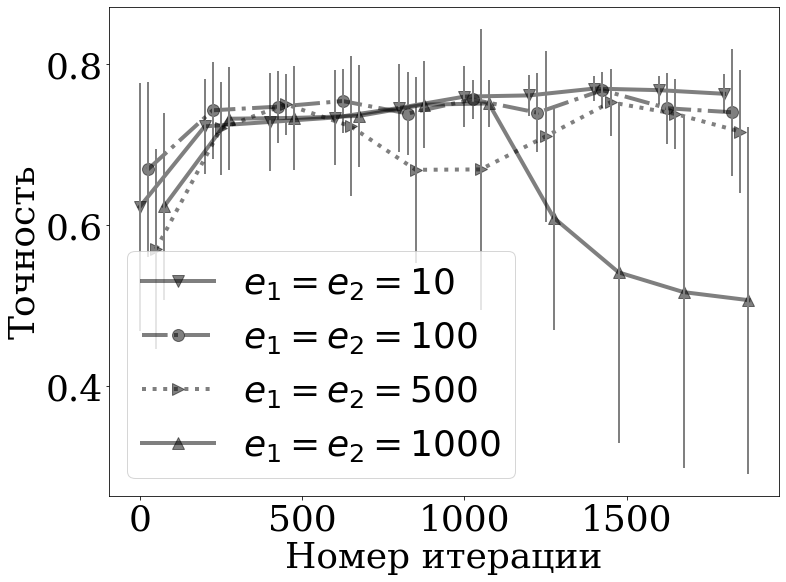

In [76]:
def plot_data_params_greyscale(data, s, label, color, sign, shift=0):
    e = np.array([data[0]['results'][i]['epoch'] for i in range(len(data[0]['results']))]) + shift
    
    
    par = np.array([subdata['results'][i][s] for i in range(len(data[0]['results'])) for subdata in data]).reshape(e.shape[0], -1)
    plt.plot(e, par.mean(1), sign, color=color, label=label, alpha=0.5, linewidth=4)
    plt.errorbar(e, par.mean(1), yerr=par.std(1), ecolor='grey', color=color, lw=0, 
                 elinewidth=2, alpha=1.0)

    


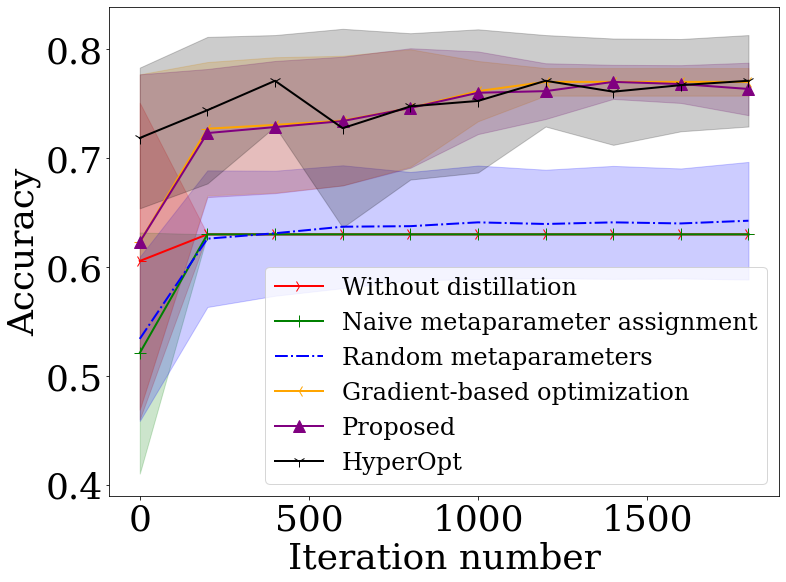

In [13]:
plot_data_params(data_b, 'accuracy', 'Without distillation', 'red', '4')
plot_data_params(data_d, 'accuracy', 'Naive metaparameter assignment', 'green', '+')
plot_data_params(data_dr, 'accuracy', 'Random metaparameters', 'blue', '.')
plot_data_params(data_h, 'accuracy', 'Gradient-based optimization', 'orange', '3')
plot_data_params(data_s, 'accuracy', 'Proposed', 'purple', '^')
plot_data_params(data_ho, 'accuracy', 'HyperOpt', 'k', '1')
plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Accuracy')
plt.savefig('../figs/synth_accuracy.pdf')

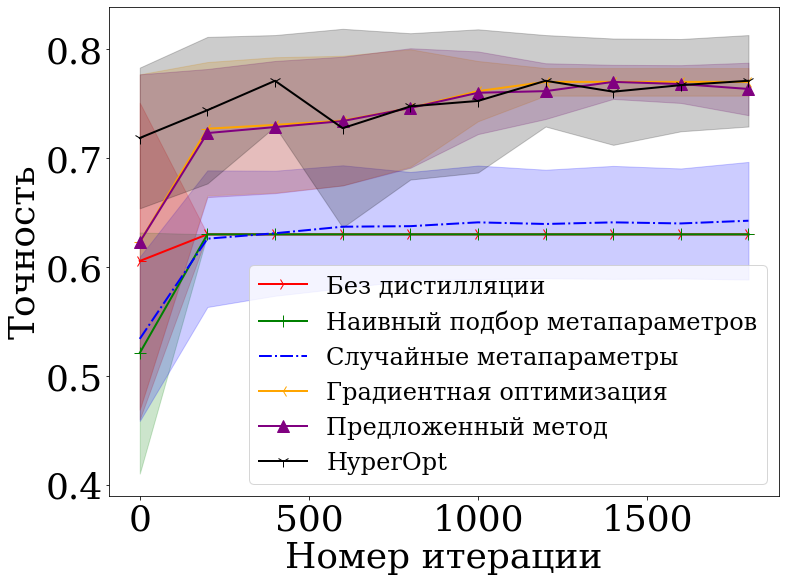

In [14]:
plot_data_params(data_b, 'accuracy', 'Без дистилляции', 'red', '4')
plot_data_params(data_d, 'accuracy', 'Наивный подбор метапараметров', 'green', '+')
plot_data_params(data_dr, 'accuracy', 'Случайные метапараметры', 'blue', '.')
plot_data_params(data_h, 'accuracy', 'Градиентная оптимизация', 'orange', '3')
plot_data_params(data_s, 'accuracy', 'Предложенный метод', 'purple', '^')
plot_data_params(data_ho, 'accuracy', 'HyperOpt', 'k', '1')
plt.legend()
plt.xlabel('Номер итерации')
plt.ylabel('Точность')
plt.savefig('../figs/synth_accuracy_rus.pdf')

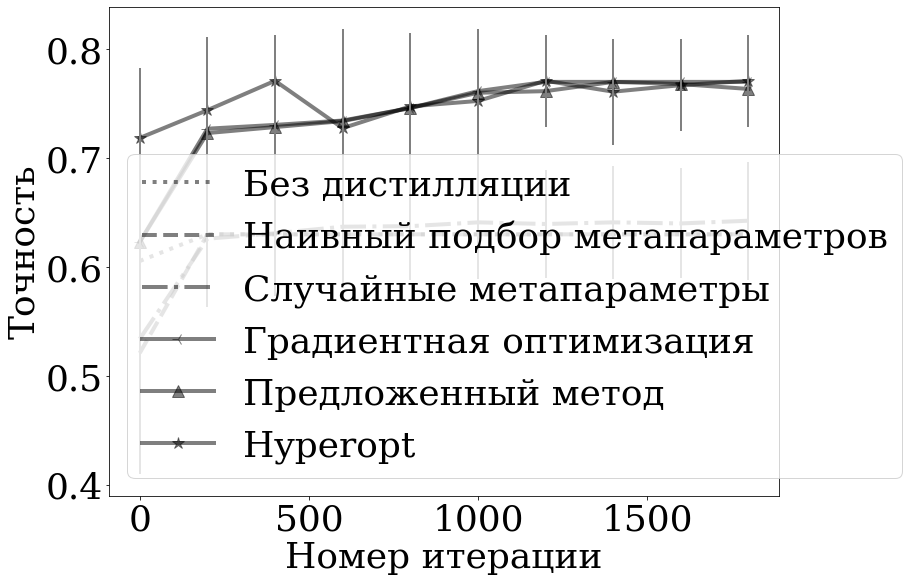

In [83]:
plot_data_params_greyscale(data_b, 'accuracy', 'Без дистилляции', 'black', ':')
plot_data_params_greyscale(data_d, 'accuracy', 'Наивный подбор метапараметров', 'black', '--')
plot_data_params_greyscale(data_dr, 'accuracy', 'Случайные метапараметры', 'black', '-.')
plot_data_params_greyscale(data_h, 'accuracy', 'Градиентная оптимизация', 'black', '-3')
plot_data_params_greyscale(data_s, 'accuracy', 'Предложенный метод', 'black', '-^')
plot_data_params_greyscale(data_ho, 'accuracy', 'Hyperopt', 'black', '-*')

plt.legend()
plt.xlabel('Номер итерации')
plt.ylabel('Точность')
plt.savefig('../figs/synth_accuracy_rus_greyscale.png')

In [8]:
from matplotlib import pylab as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 36
plt.rcParams['ytick.labelsize'] = 36
plt.rcParams['legend.fontsize'] = 36
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 36

In [9]:
data_10 = open_data_json("../log/synthetic_exp8_splines_esize_10_period_2.jsonl")
data_100 = open_data_json("../log/synthetic_exp8_splines_esize_100_period_2.jsonl")
data_500 = open_data_json("../log/synthetic_exp8_splines_esize_500_period_2.jsonl")
data_1000 = open_data_json("../log/synthetic_exp8_splines_esize_1000_period_2.jsonl")


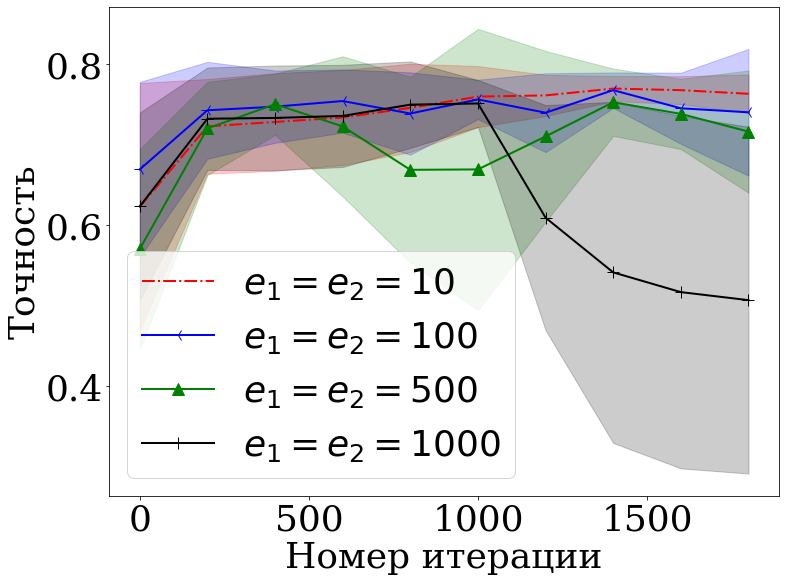

In [6]:
plot_data_params(data_10, 'accuracy', '$e_1 = e_2 = 10$', 'red', '.')
plot_data_params(data_100, 'accuracy', '$e_1 = e_2 = 100$', 'blue', '3')
plot_data_params(data_500, 'accuracy', '$e_1 = e_2 = 500$', 'green', '^')
plot_data_params(data_1000, 'accuracy', '$e_1 = e_2 = 1000$', 'black', '+')

plt.legend()
plt.xlabel('Номер итерации')
plt.ylabel('Точность')
# plt.title('График зависимости точности классификации от\n номера итерации при различных значениях размера эпохи')
plt.savefig('../figs/synth_mini_epoch_size_rus.pdf')
plt.show()

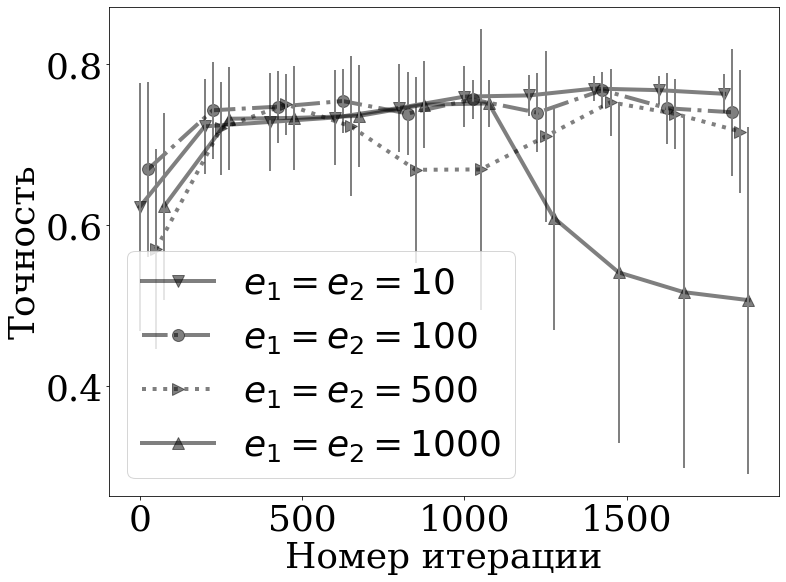

In [77]:
plot_data_params_greyscale(data_10, 'accuracy', '$e_1 = e_2 = 10$', 'black', '-v')
plot_data_params_greyscale(data_100, 'accuracy', '$e_1 = e_2 = 100$', 'black', '-.o', shift=25)
plot_data_params_greyscale(data_500, 'accuracy', '$e_1 = e_2 = 500$', 'black', ':>', shift=50)
plot_data_params_greyscale(data_1000, 'accuracy', '$e_1 = e_2 = 1000$', 'black', '-^', shift=75)

plt.legend()
plt.xlabel('Номер итерации')
plt.ylabel('Точность')
# plt.title('График зависимости точности классификации от\n номера итерации при различных значениях размера эпохи')
plt.savefig('../figs/synth_mini_epoch_size_rus_greyscale.png')
plt.show()    

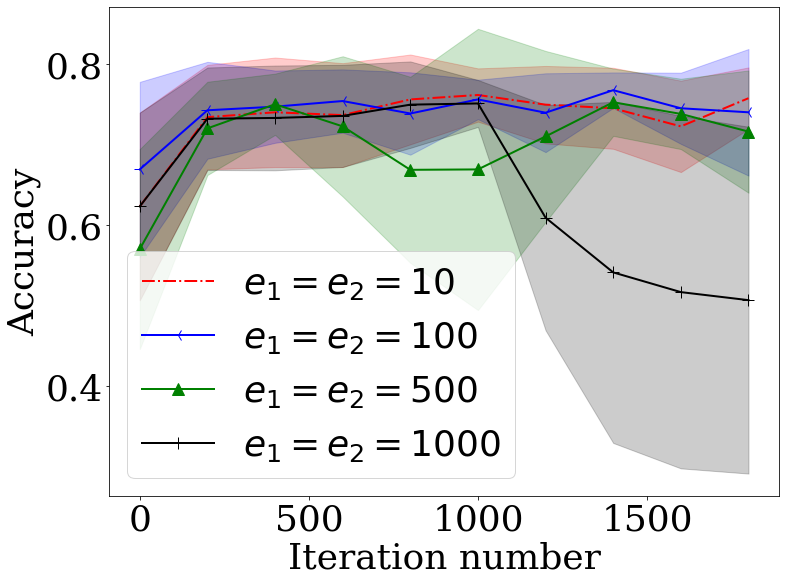

In [42]:
plot_data_params(data_10, 'accuracy', '$e_1 = e_2 = 10$', 'red', '.')
plot_data_params(data_100, 'accuracy', '$e_1 = e_2 = 100$', 'blue', '3')
plot_data_params(data_500, 'accuracy', '$e_1 = e_2 = 500$', 'green', '^')
plot_data_params(data_1000, 'accuracy', '$e_1 = e_2 = 1000$', 'black', '+')

plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Accuracy')
# plt.title('График зависимости точности классификации от\n номера итерации при различных значениях размера эпохи')
plt.savefig('../figs/synth_mini_epoch_size.pdf')
plt.show()

NameError: name 'data_2000' is not defined

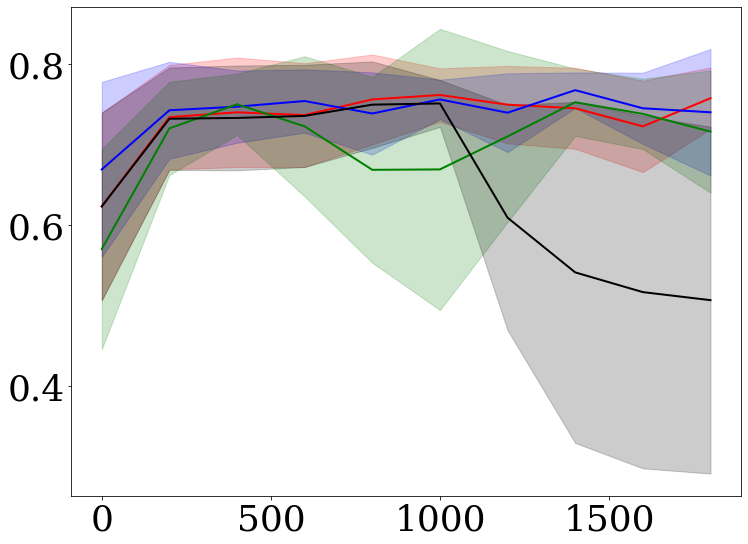

In [43]:
plot_data_params(data_10, 'accuracy', '10 iterations in epoch', 'red', '')
plot_data_params(data_100, 'accuracy', '100 iterations in epoch', 'blue', '')
plot_data_params(data_500, 'accuracy', '500 iterations in epoch', 'green', '')
plot_data_params(data_1000, 'accuracy', '1000 iterations in epoch', 'black', '')
plot_data_params(data_2000, 'accuracy', '2000 iterations in epoch', 'orange', '')
plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Accuracy')
# plt.title('График зависимости точности классификации от\n номера итерации при различных значениях размера эпохи')
plt.savefig('../figs/synthetic_exp3_linear_epoch_size_color.pdf')
plt.show()

In [79]:
data_2 = open_data_json("../log/synthetic_exp8_splines_esize_10_period_2.jsonl")
data_3 = open_data_json("../log/synthetic_exp8_splines_esize_10_period_3.jsonl")
data_5 = open_data_json("../log/synthetic_exp8_splines_esize_10_period_5.jsonl")
data_10 = open_data_json("../log/synthetic_exp8_splines_esize_10_period_10.jsonl")

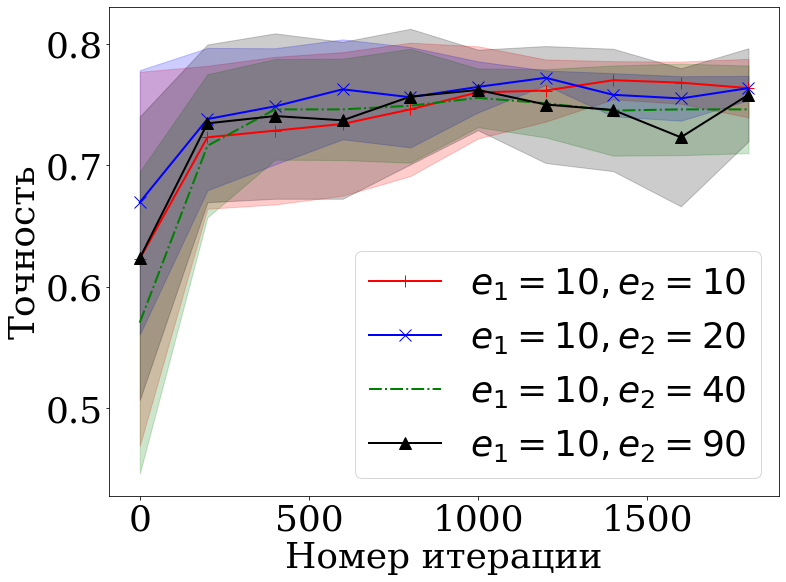

In [9]:
plot_data_params(data_2, 'accuracy', '$e_1 = 10, e_2 = 10$', 'red', '+')
plot_data_params(data_3, 'accuracy', '$e_1 = 10, e_2 = 20$', 'blue', 'x')
plot_data_params(data_5, 'accuracy', '$e_1 = 10, e_2 = 40$', 'green', '.')
plot_data_params(data_10, 'accuracy', '$e_1 = 10, e_2 = 90$', 'black', '^')
plt.legend()
plt.xlabel('Номер итерации')
plt.ylabel('Точность')
# plt.title('График зависимости точности классификации от\n номера итерации при различных train_splines_every_epoch')
plt.savefig('../figs/synth_period_rus.pdf')
plt.show()

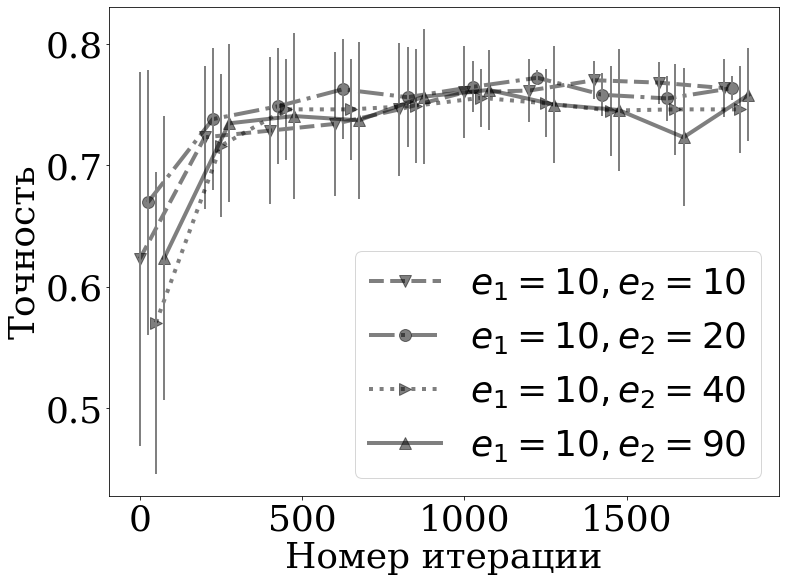

In [82]:
plot_data_params_greyscale(data_2, 'accuracy', '$e_1 = 10, e_2 = 10$', 'black', '--v')
plot_data_params_greyscale(data_3, 'accuracy', '$e_1 = 10, e_2 = 20$', 'black', '-.o', shift=25)
plot_data_params_greyscale(data_5, 'accuracy', '$e_1 = 10, e_2 = 40$', 'black', ':>', shift=50)
plot_data_params_greyscale(data_10, 'accuracy', '$e_1 = 10, e_2 = 90$', 'black', '-^', shift=75)
plt.legend()
plt.xlabel('Номер итерации')
plt.ylabel('Точность')
# plt.title('График зависимости точности классификации от\n номера итерации при различных train_splines_every_epoch')
plt.savefig('../figs/synth_period_rus_greyscale.png')
plt.show()

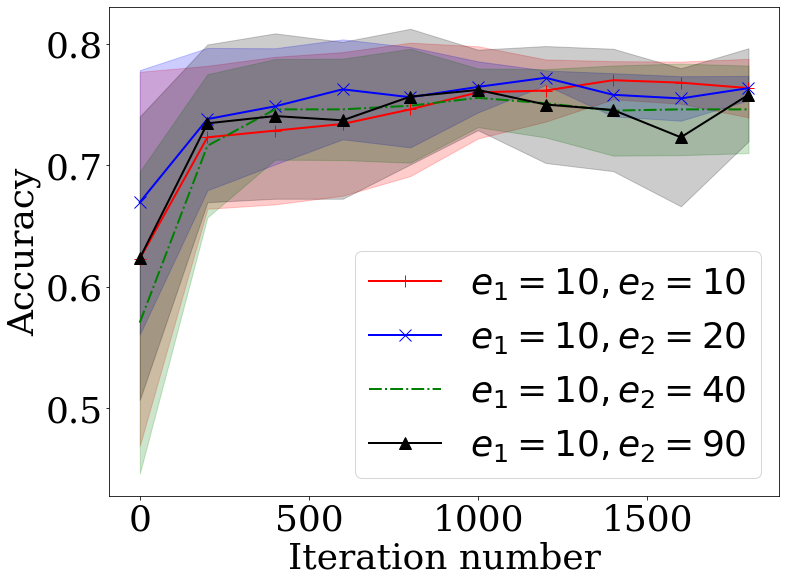

In [11]:
plot_data_params(data_2, 'accuracy', '$e_1 = 10, e_2 = 10$', 'red', '+')
plot_data_params(data_3, 'accuracy', '$e_1 = 10, e_2 = 20$', 'blue', 'x')
plot_data_params(data_5, 'accuracy', '$e_1 = 10, e_2 = 40$', 'green', '.')
plot_data_params(data_10, 'accuracy', '$e_1 = 10, e_2 = 90$', 'black', '^')
plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Accuracy')
# plt.title('График зависимости точности классификации от\n номера итерации при различных train_splines_every_epoch')
plt.savefig('../figs/synth_period.pdf')
plt.show()

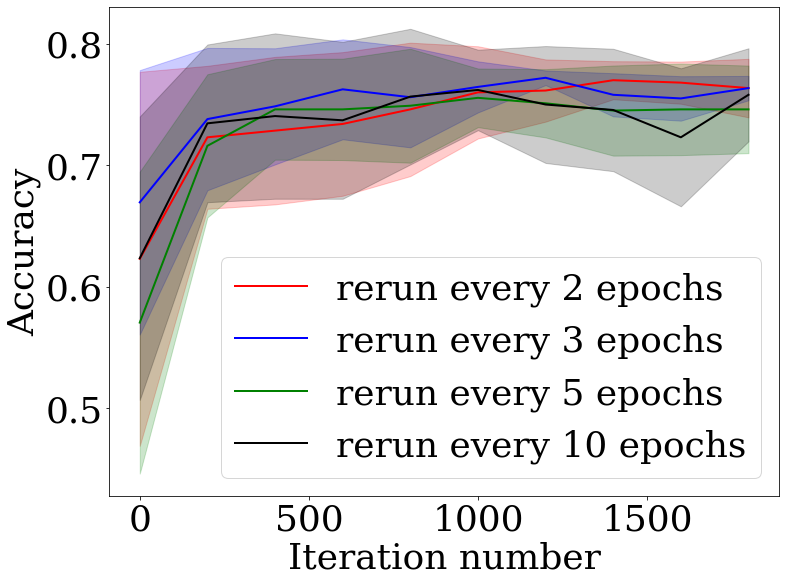

In [10]:
plot_data_params(data_2, 'accuracy', 'rerun every 2 epochs', 'red', '')
plot_data_params(data_3, 'accuracy', 'rerun every 3 epochs', 'blue', '')
plot_data_params(data_5, 'accuracy', 'rerun every 5 epochs', 'green', '')
plot_data_params(data_10, 'accuracy', 'rerun every 10 epochs', 'black', '')
plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Accuracy')
# plt.title('График зависимости точности классификации от\n номера итерации при различных train_splines_every_epoch')
plt.savefig('../figs/synthetic_exp3_linear_train_splines_every_epoch_color.pdf')
plt.show()

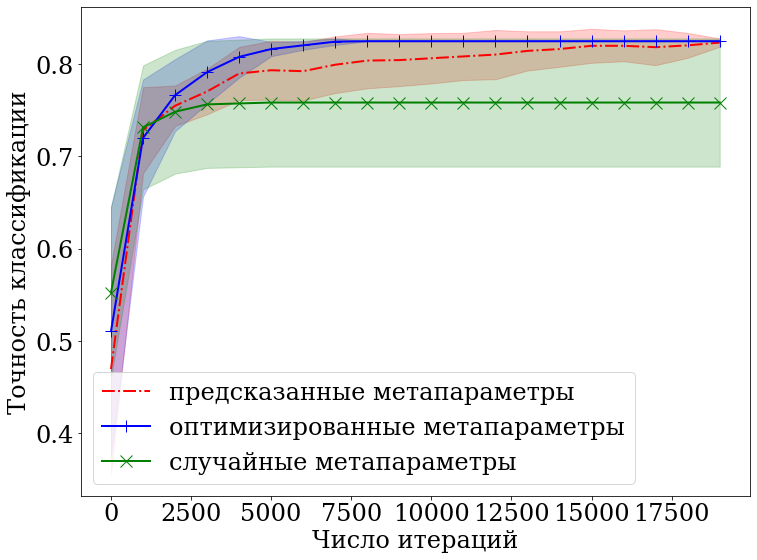

In [21]:
plot_data_params(data_s, 'accuracy', 'predicted meta-parameters', 'red', '.')
plot_data_params(data_h, 'accuracy', 'meta-parameter optimization', 'blue', '+')
plot_data_params(data_dr, 'accuracy', 'random meta-parameters', 'green', 'x')
plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Accuracy')
# plt.title('График зависимости точности классификации от\n номера итерации')
plt.savefig('../figs/synthetic_exp3_acc_iter.pdf')
plt.show()

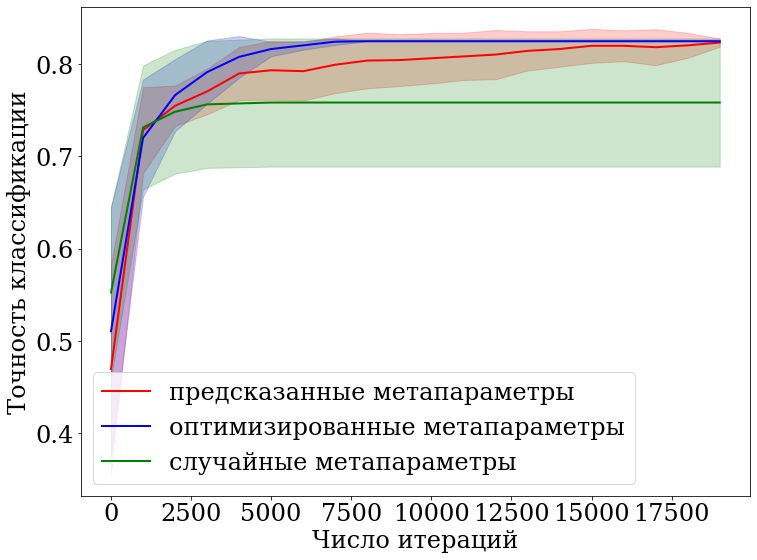

In [20]:
plot_data_params(data_s, 'accuracy', 'predicted meta-parameters', 'red', '')
plot_data_params(data_h, 'accuracy', 'meta-parameter optimization', 'blue', '')
plot_data_params(data_dr, 'accuracy', 'random meta-parameters', 'green', '')
plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Accuracy')
# plt.title('График зависимости точности классификации от\n номера итерации')
plt.savefig('../figs/synthetic_exp3_acc_iter_color.pdf')
plt.show()

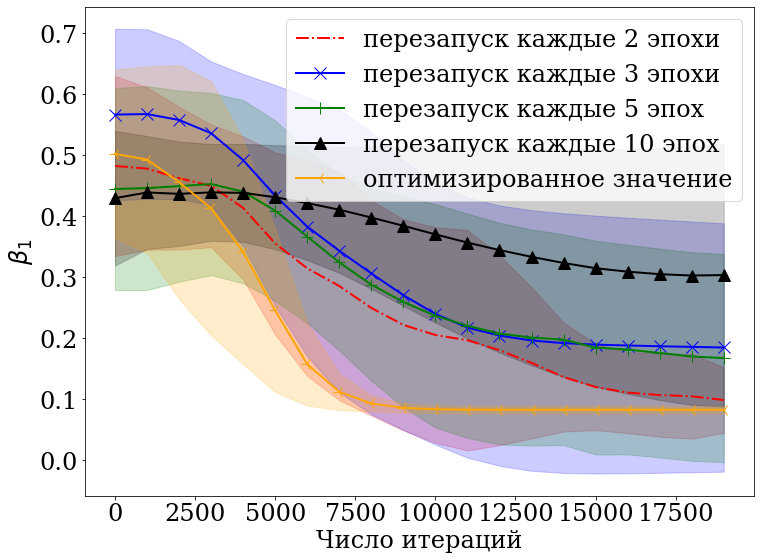

In [28]:
plot_data_params(data_spline2, 'lambda1', 'rerun every 2 epochs', 'red', '.')
plot_data_params(data_spline3, 'lambda1', 'rerun every 3 epochs', 'blue', 'x')
plot_data_params(data_spline5, 'lambda1', 'rerun every 5 epochs', 'green', '+')
plot_data_params(data_spline10, 'lambda1', 'rerun every 10 epochs', 'black', '^')

plt.xlabel('Iteration number')
plt.ylabel(r'$\lambda_1$')
# plt.title(r'График зависимости значения $\lambda_1$ от номера итерации')
plt.legend()
plt.savefig('../figs/synthetic_exp3_lambda1_iter.pdf')
plt.show()

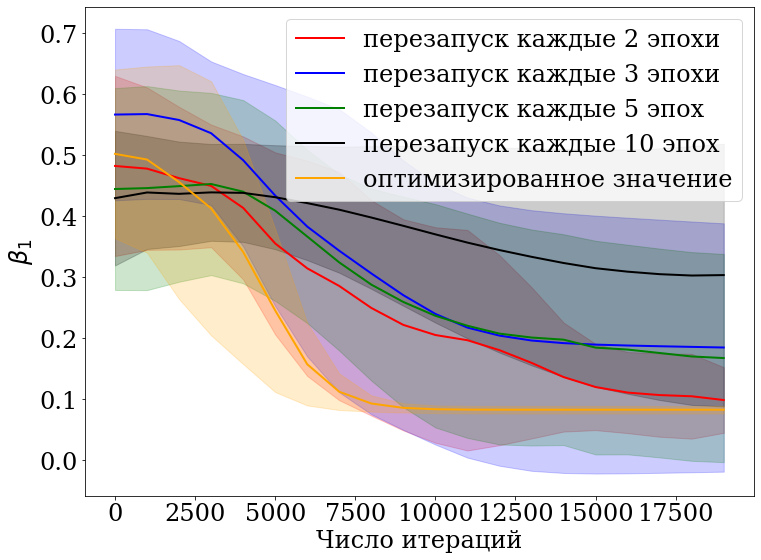

In [29]:
plot_data_params(data_spline2, 'lambda1', 'rerun every 2 epochs', 'red', '')
plot_data_params(data_spline3, 'lambda1', 'rerun every 3 epochs', 'blue', '')
plot_data_params(data_spline5, 'lambda1', 'rerun every 5 epochs', 'green', '')
plot_data_params(data_spline10, 'lambda1', 'rerun every 10 epochs', 'black', '')

plt.xlabel('Iteration number')
plt.ylabel(r'$\lambda_1$')
# plt.title(r'График зависимости значения $\lambda_1$ от номера итерации')
plt.legend()
plt.savefig('../figs/synthetic_exp3_lambda1_iter_color.pdf')
plt.show()

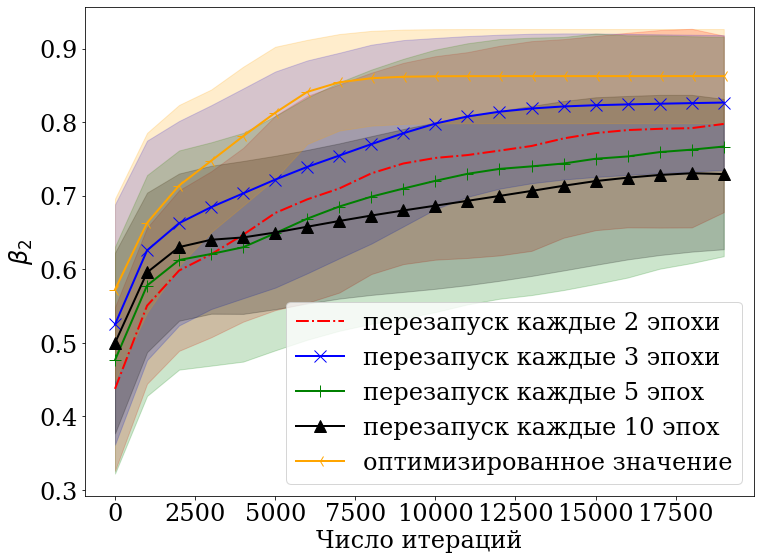

In [30]:
plot_data_params(data_spline2, 'lambda2', 'rerun every 2 epochs', 'red', '.')
plot_data_params(data_spline3, 'lambda2', 'rerun every 3 epochs', 'blue', 'x')
plot_data_params(data_spline5, 'lambda2', 'rerun every 5 epochs', 'green', '+')
plot_data_params(data_spline10, 'lambda2','rerun every 10 epochs', 'black', '^')

plt.xlabel('Iteration number')
plt.ylabel(r'$\lambda_2$')
# plt.title(r'График зависимости значения $\lambda_2$ от номера итерации')
plt.legend()
plt.savefig('../figs/synthetic_exp3_lambda2_iter.pdf')
plt.show()

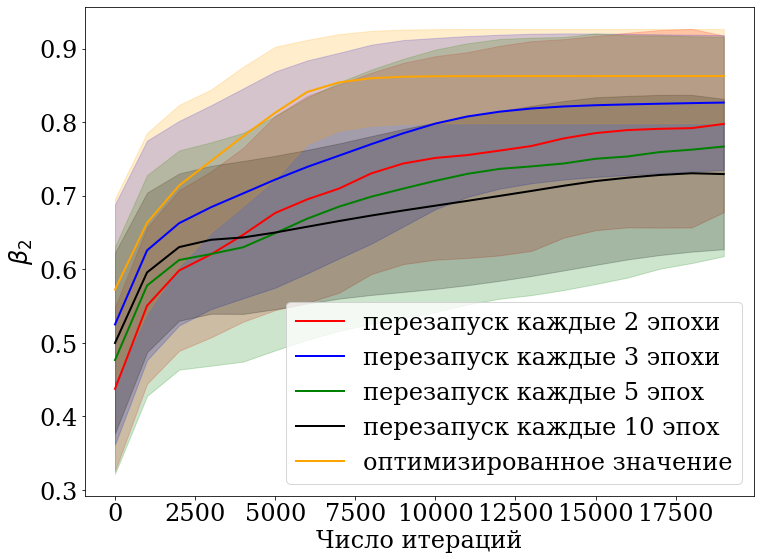

In [31]:
plot_data_params(data_spline2, 'lambda2', 'rerun every 2 epochs', 'red', '')
plot_data_params(data_spline3, 'lambda2', 'rerun every 3 epochs', 'blue', '')
plot_data_params(data_spline5, 'lambda2', 'rerun every 5 epochs', 'green', '')
plot_data_params(data_spline10, 'lambda2', 'rerun every 10 epochs', 'black', '')

plt.xlabel('Iteration number')
plt.ylabel(r'$\lambda_2$')
# plt.title(r'График зависимости значения $\lambda_2$ от номера итерации')
plt.legend()
plt.savefig('../figs/synthetic_exp3_lambda2_iter_color.pdf')
plt.show()

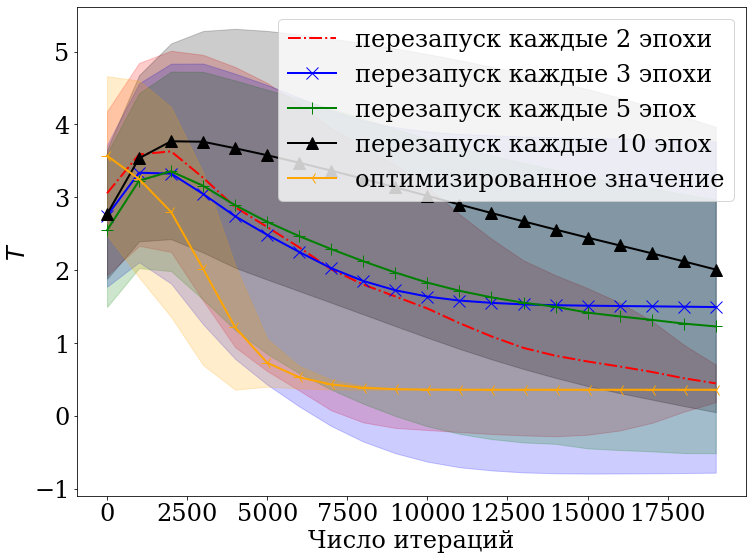

In [32]:
plot_data_params(data_spline2, 'temp', 'rerun every 2 epochs', 'red', '.')
plot_data_params(data_spline3, 'temp', 'rerun every 3 epochs', 'blue', 'x')
plot_data_params(data_spline5, 'temp', 'rerun every 5 epochs', 'green', '+')
plot_data_params(data_spline10, 'temp', 'rerun every 10 epochs', 'black', '^')

plt.xlabel('Iteration number')
plt.ylabel(r'$T$')
# plt.title(r'График зависимости значения $T$ от номера итерации')
plt.legend()
plt.savefig('../figs/synthetic_exp3_temp_iter.pdf')
plt.show()

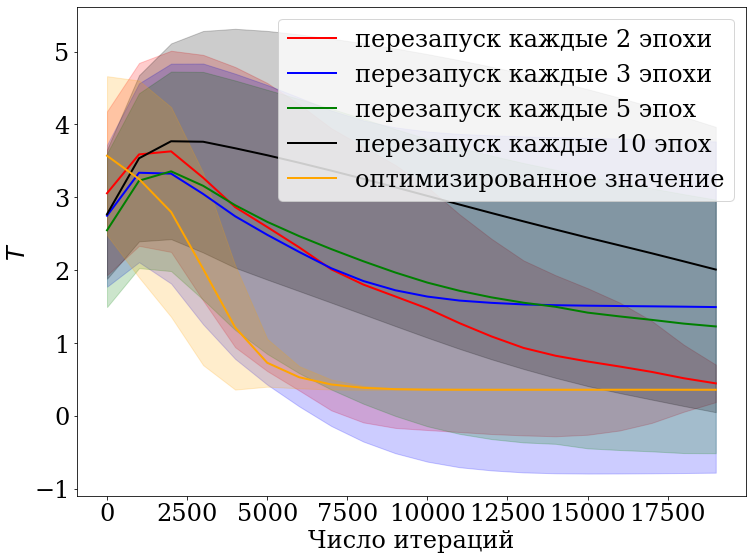

In [33]:
plot_data_params(data_spline2, 'temp', 'rerun every 2 epochs', 'red', '')
plot_data_params(data_spline3, 'temp', 'rerun every 3 epochs', 'blue', '')
plot_data_params(data_spline5, 'temp', 'rerun every 5 epochs', 'green', '')
plot_data_params(data_spline10, 'temp', 'rerun every 10 epochs', 'black', '')

plt.xlabel('Iteration number')
plt.ylabel(r'$T$')
# plt.title(r'График зависимости значения $T$ от номера итерации')
plt.legend()
plt.savefig('../figs/synthetic_exp3_temp_iter_color.pdf')
plt.show()